In [1]:
import os, sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

from retrieval import index
from retrieval import search
import pipeline

from PIL import Image

## Calculate Mean Average Precision For the Two Models ##

1. Casia-webface

Load Casia-webface model (default) and performance check on different k values. Here we are using minkowski metric.

In [2]:
findex = index.FaissIndex(faiss_index_type='Flat',  metric='minkowski')
# findex.load('../storage/catalog/faiss.index', '../storage/catalog/metadata.pkl')
findex.load(faiss_path = '../storage/catalog/faiss.index', metadata_path = '../storage/catalog/metadata.pkl')

pline = pipeline.Pipeline(image_size=160, model_device='cuda')
pline.faiss_index = findex

/home/kaneel123/.local/lib/python3.8/site-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(c

In [3]:
#get probe dirs
probe_dir = '../simclr_resources/probe'

#k vals 
ks = [5, 10, 20, 25, 50]
results_casia = {}

for k in ks:

    #start a new mAP calculation for new k values
    mAP_total = 0
    total_probes = 0

    for root, dirs, files in os.walk(probe_dir):

        for file in files:

            try:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    
                    #get person name    
                    person_name = os.path.basename(root)
                    
                    # Load image
                    image_path = os.path.join(root, file)
                    image_probe = Image.open(image_path)

                    #predict using the model
                    out = pline.search_gallery(image_probe, k = k)

                    #predicted names 
                    out_names = [o['name'] for o in out]

                    #calculate mean average precision
                    count = 0
                    ap = 0
                    for i, o in enumerate(out_names):
                        if person_name == o:
                            count += 1
                            prec = count/(i + 1)
                            ap += prec

                    
                    if count > 0:
                        ap /= count

                    total_probes += 1
                    mAP_total += ap                             

            except:
                pass

    mAP = mAP_total / total_probes if total_probes > 0 else 0
    results_casia[k] = mAP

2. vggface2

Test vggface2 model with different k values. The metric will be again be mikowski.

In [4]:
findexvgg = index.FaissIndex(faiss_index_type='Flat',  metric='minkowski')
# findex.load('../storage/catalog/faiss.index', '../storage/catalog/metadata.pkl')
findexvgg.load(faiss_path = '../storage/catalog_vgg/faiss.index', metadata_path = '../storage/catalog_vgg/metadata.pkl')

pline2 = pipeline.Pipeline(image_size=160, model_device='cuda', pretrained='vggface2')
pline2.faiss_index = findexvgg

In [5]:
#get probe dirs
probe_dir = '../simclr_resources/probe'

#k vals 
ks = [5, 10, 20, 25, 50]
results_vgg = {}

for k in ks:

    #start a new mAP calculation for new k values
    mAP_total = 0
    total_probes = 0

    for root, dirs, files in os.walk(probe_dir):

        for file in files:

            try:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    
                    #get person name    
                    person_name = os.path.basename(root)
                    
                    # Load image
                    image_path = os.path.join(root, file)
                    image_probe = Image.open(image_path)

                    #predict using the model
                    out = pline2.search_gallery(image_probe, k = k)

                    #predicted names 
                    out_names = [o['name'] for o in out]

                    #calculate mean average precision
                    count = 0
                    ap = 0
                    # relevant_count = sum(1 for name in out_names if name == person_name)
                    for i, o in enumerate(out_names):
                        if person_name == o:
                            count += 1
                            prec = count/(i + 1)
                            ap += prec

                    if count > 0:
                        ap /= count
                    
                    total_probes += 1
                    mAP_total += ap                      

            except:
                pass

    mAP = mAP_total / total_probes if total_probes > 0 else 0
    results_vgg[k] = mAP

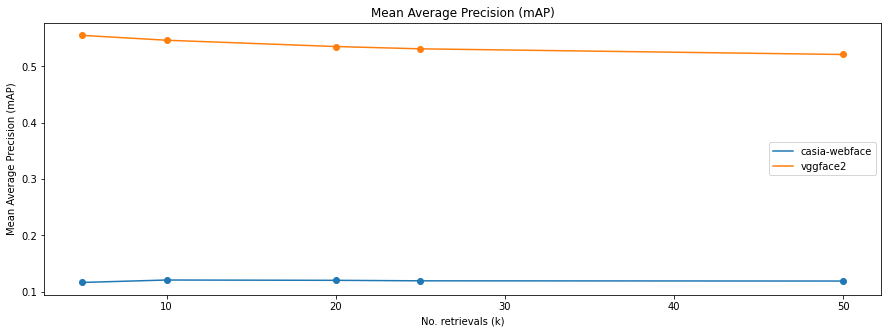

In [6]:
import matplotlib.pyplot as plt
#plot results
plt.figure(figsize = (15, 5))
plt.plot(list(results_casia.keys()), list(results_casia.values()), label = 'casia-webface')
plt.scatter(list(results_casia.keys()), list(results_casia.values()))
plt.plot(list(results_vgg.keys()), list(results_vgg.values()), label = 'vggface2')
plt.scatter(list(results_vgg.keys()), list(results_vgg.values()))
plt.legend()
plt.title('Mean Average Precision (mAP)')
plt.xlabel('No. retrievals (k)')
plt.ylabel('Mean Average Precision (mAP)')
plt.show()

Lookng at the mean Average precision the winner is 'vggface2'. Looking at the 'vggface-2' results increasing the number of retrivals drags the mAP down. So using a k = 5 and a vggface2 model with 'minkowski' distance seems to be a the best choice. The 'casia-webface' model seems to have significantly low performance compared to vggface-2. The performance slightly increases when k = 10 and then decreases with more retrievals. 

## Check impact of brightness adjustments to each model ##

Since one of the critical requirements is it's ability to work under difference brightness conditions, let's adjust the brightness of the best model above, to see its performance. We will use the PIL brigtness enhancer to adjust the brightness from 0 to 5 and see its impact towards the mAP.

In [15]:
from PIL import ImageEnhance

#get probe dirs
probe_dir = '../simclr_resources/probe'

#k vals 
bs = [0.1, 0.5, 0.75, 1, 1.5, 2.5]
results_vgg_badjust = {}

for b in bs:

    #start a new mAP calculation for new k values
    mAP_total = 0
    total_probes = 0

    for root, dirs, files in os.walk(probe_dir):

        for file in files:

            try:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    
                    #get person name    
                    person_name = os.path.basename(root)
                    
                    # Load image
                    image_path = os.path.join(root, file)
                    image_probe = Image.open(image_path)

                    # Create an enhancer object for brightness adjustment
                    enhancer = ImageEnhance.Brightness(image_probe)
                    bright_image = enhancer.enhance(b)

                    #predict using the model
                    out = pline2.search_gallery(bright_image, k = 5)
                    
                    #predicted names 
                    out_names = [o['name'] for o in out]

                    #calculate mean average precision
                    count = 0
                    ap = 0
                    # relevant_count = sum(1 for name in out_names if name == person_name)
                    for i, o in enumerate(out_names):
                        if person_name == o:
                            count += 1
                            prec = count/(i + 1)
                            ap += prec

                    if count > 0:
                        ap /= count
                    
                    total_probes += 1
                    mAP_total += ap                      

            except:
                pass

    mAP = mAP_total / total_probes if total_probes > 0 else 0
    results_vgg_badjust[b] = mAP

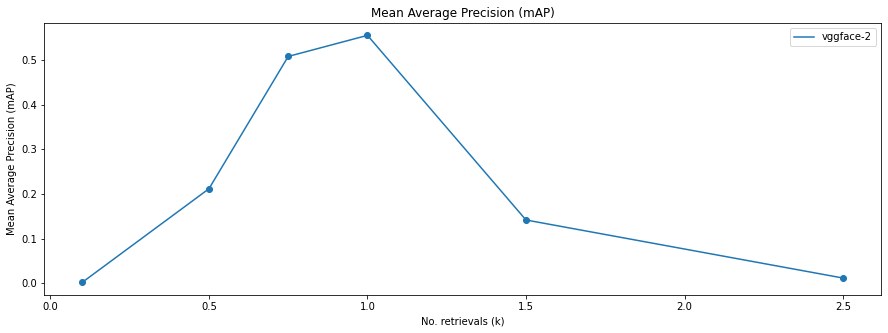

In [17]:
#plot results
plt.figure(figsize = (15, 5))
plt.plot(list(results_vgg_badjust.keys()), list( results_vgg_badjust.values()), label = 'vggface-2')
plt.scatter(list(results_vgg_badjust.keys()), list(results_vgg_badjust.values()))
plt.legend()
plt.title('Mean Average Precision (mAP)')
plt.xlabel('No. retrievals (k)')
plt.ylabel('Mean Average Precision (mAP)')
plt.show()

The mean average precision for the 'vggface-2' model is at the highest when the brightness level is at 1. This is the point where the image brightness is not applied. When brightness is applied to the images, the map value tend to go down. WHen extreme brightness is applied the mAP reaches values 0.001 and 0.01 for a brightness factor of 0.1 and 2.5 respectively. So, it is clear that the best model face identification accuracy declines when the brightness is fluctuating. 